In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
  
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split 

import cv2 
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3 
from keras import layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau 
from functools import partial 
  
import warnings 
warnings.filterwarnings('ignore') 
AUTO = tf.data.experimental.AUTOTUNE

import albumentations as A 

In [2]:
## Lets use these images to test our model (upon reconstruction)
labels = '/Users/aaronestes/projects/Hello_World/Poetry/labels.csv'

alex_dog_german_shepherd = '/Users/aaronestes/projects/Hello_World/Poetry/test_images/alex_dog_german_shepherd.jpg'
alex_dog_lab_retriever = '/Users/aaronestes/projects/Hello_World/Poetry/test_images/alex_dog_lab_retriever.jpg'
ozzy = '/Users/aaronestes/projects/Hello_World/Poetry/test_images/ozzy.jpg'
ozzy_grandmas_house = '/Users/aaronestes/projects/Hello_World/Poetry/test_images/ozzy_grandmas_house.jpg'
test_img = alex_dog_german_shepherd

x_model_name = 'x_model'

In [3]:
def extract_contents_from_zip():
    ## only need to do this one time
    from zipfile import ZipFile
    data_path = '/Users/aaronestes/projects/Hello_World/Poetry/dog-breed-identification.zip'
    with ZipFile(data_path, 'r') as zip: 
        zip.extractall() 
        print('The data set has been extracted.')

# extract_contents_from_zip()

In [4]:
def read_labels() -> pd.DataFrame:
    return pd.read_csv(labels)

df = read_labels()

In [5]:
## Were not using this anywhere else,
## just checking out the data we're working with
def get_num_dog_breeds(df: pd.DataFrame) -> int:
    return df['breed'].nunique()

num_dog_breeds = get_num_dog_breeds(df)

In [6]:
## Lets check out the distribution of these dog breeds
def plot_dog_breeds(df: pd.DataFrame):
    plt.figure(figsize=(10, 5)) 
    df['breed'].value_counts().plot.bar() 
    plt.axis('off') 
    plt.show() 

# plot_dog_breeds(df)

In [7]:
## lets make a column in our dataframe for filepath
## equal to the relative path for each image in our training set data
def df_add_col(df: pd.DataFrame):
    return 'train/' + df['id'] + '.jpg'

df['filepath'] = df_add_col(df)

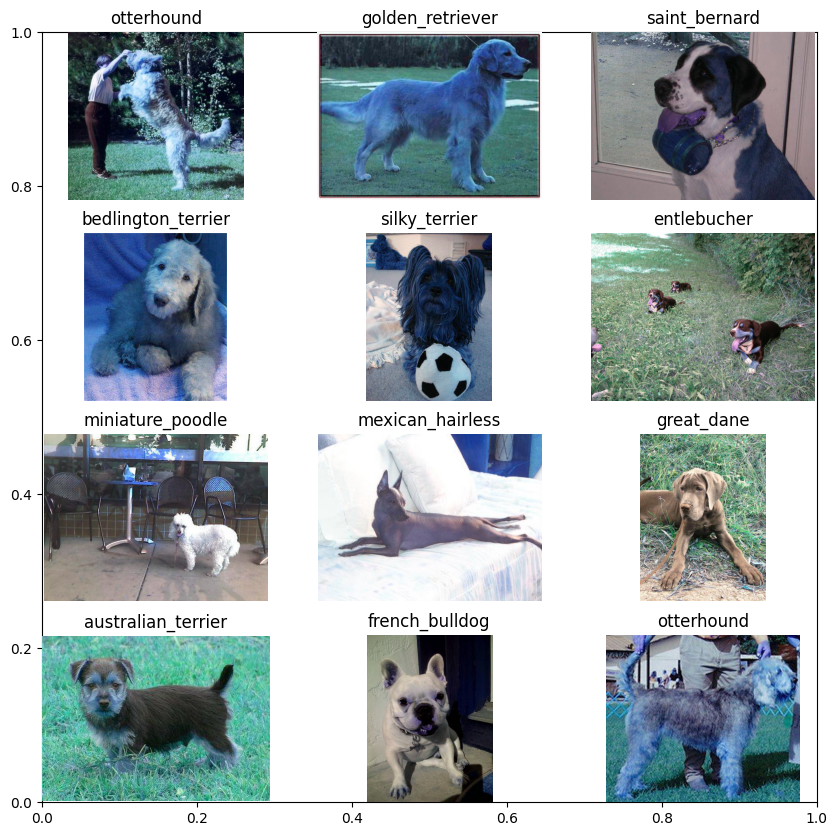

In [8]:
def display_image(df: pd.DataFrame, random_int: int):
    img = cv2.imread(df.loc[random_int, 'filepath']) 
    plt.imshow(img)

def display_name(df, random_int: int):
    plt.title(df.loc[random_int, 'breed']) 
    plt.axis('off')     

def visualize_n_random_dogs(n: int, df: pd.DataFrame):
    plt.subplots(figsize=(10, 10)) 
    for i in range(n): 
        plt.subplot(4, 3, i+1) 
        k = np.random.randint(0, len(df)) 
        display_image(df, k)
        display_name(df, k)
    plt.show()

visualize_n_random_dogs(12, df)

In [9]:
df.head() 

,id,breed,filepath
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,train/0021f9ceb3235effd7fcde7f7538ed62.jpg


In [10]:
df.to_csv("df_with_name.csv")

In [11]:
le = LabelEncoder() 
df['breed'] = le.fit_transform(df['breed']) 

In [12]:
df.head() 

,id,breed,filepath
0,000bec180eb18c7604dcecc8fe0dba07,19,train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,37,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,85,train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,15,train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,49,train/0021f9ceb3235effd7fcde7f7538ed62.jpg


In [13]:
## lets save our dataframe to the disk
## for debugging purposes
def save_(df: pd.DataFrame):
    df.to_csv('temp.csv')
save_(df)

In [14]:
def extract_data(df: pd.DataFrame):
    return df['filepath'], df['breed']

def split_data(features: pd.core.series.Series, target: pd.core.series.Series, test_size: float, random_state: int):
    return train_test_split(features, target, test_size=test_size, random_state=random_state)

features, target = extract_data(df)
test_size = 0.15
random_state = 10
X_train, X_test, Y_train, Y_test = split_data(features, target, test_size, random_state) 

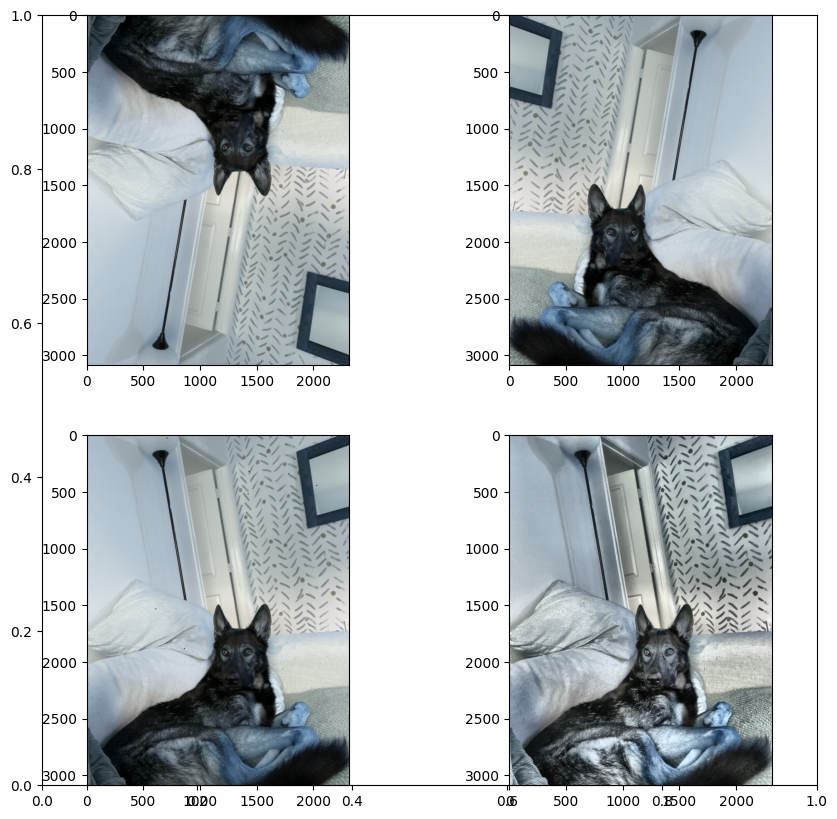

In [18]:
def get_transform_train() -> A.core.composition.Compose:
    return A.Compose([ 
    A.VerticalFlip(p=0.2), 
    A.HorizontalFlip(p=0.7), 
    A.CoarseDropout(p=0.5), 
    A.RandomGamma(p=0.5), 
    A.RandomBrightnessContrast(p=1) 
]) 
  
transforms_train = get_transform_train()

# ## Lets see what these augmentations do to an image of Alex's dog

img = cv2.imread(test_img) 
augments = [A.VerticalFlip(p=1), A.HorizontalFlip(p=1), 
            A.CoarseDropout(p=1), A.CLAHE(p=1)] 
  
plt.subplots(figsize=(10, 10)) 
for i, aug in enumerate(augments): 
    plt.subplot(2, 2, i+1) 
    aug_img = aug(image=img)['image'] 
    plt.imshow(aug_img) 
plt.show() 

In [20]:
def aug_fn(img): 
    aug_data = transforms_train(image=img) 
    aug_img = aug_data['image'] 
    return aug_img 
  
@tf.function 
def process_data(img, label): 
    aug_img = tf.numpy_function(aug_fn, [img], Tout=tf.float32) 
    return img, label 
  
def decode_image(filepath, label=None): 
    img = tf.io.read_file(filepath) 
    img = tf.image.decode_jpeg(img) 
    img = tf.image.resize(img, [128, 128]) 
    img = tf.cast(img, tf.float32) / 255.0
  
    if label == None: 
        return img 
  
    return img, tf.one_hot(indices=label, 
                           depth=120, 
                           dtype=tf.float32) 

In [21]:
train_ds = ( 
    tf.data.Dataset 
    .from_tensor_slices((X_train, Y_train)) 
    .map(decode_image, num_parallel_calls=AUTO) 
    .map(partial(process_data), num_parallel_calls=AUTO) 
    .batch(32) 
    .prefetch(AUTO) 
) 
  
test_ds = ( 
    tf.data.Dataset 
    .from_tensor_slices((X_test, Y_test)) 
    .map(decode_image, num_parallel_calls=AUTO) 
    .batch(32) 
    .prefetch(AUTO) 
)

pre_trained_model = InceptionV3( 
    input_shape=(128, 128, 3), 
    weights='imagenet', 
    include_top=False
) 
# len(pre_trained_model.layers)

for layer in pre_trained_model.layers: 
  layer.trainable = False
  
last_layer = pre_trained_model.get_layer('mixed7') 
print('last layer output shape: ', last_layer.output_shape) 
last_output = last_layer.output

# Model Architecture 
x = layers.Flatten()(last_output) 
x = layers.Dense(256, activation='relu')(x) 
x = layers.BatchNormalization()(x) 
x = layers.Dense(256, activation='relu')(x) 
x = layers.Dropout(0.3)(x) 
x = layers.BatchNormalization()(x) 
output = layers.Dense(num_dog_breeds, activation='softmax')(x) 
  
model = keras.Model(pre_trained_model.input, output) 
  
# Model Compilation 
model.compile( 
    optimizer='adam', 
    loss=keras.losses.CategoricalCrossentropy(from_logits=True), 
    metrics=['AUC'] 
)

class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if logs.get('val_auc') > 0.99: 
            print('\n Validation accuracy has reached upto 90% so, stopping further training.') 
            self.model.stop_training = True
  
es = EarlyStopping(patience=3, 
                   monitor='val_auc', 
                   restore_best_weights=True) 
  
lr = ReduceLROnPlateau(monitor='val_loss', 
                       patience=2, 
                       factor=0.5, 
                       verbose=1)

history = model.fit(train_ds, 
                    validation_data=test_ds, 
                    epochs=50, 
                    verbose=1, 
                    callbacks=[es, lr, myCallback()])
model.save(x_model_name) 